In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

In [2]:
dfs = [pd.read_csv('user_a.csv')]

In [3]:
for i in range(len(dfs)):
    dfs[i]['User'] = pd.Series(i, index=dfs[i].index)

In [4]:
 data = pd.concat(dfs, axis=0).sample(frac=1.0, random_state=123).reset_index(drop=True)

In [5]:
 # data = data[data.columns.drop(list(data.filter(regex='beta')))]

In [6]:
 data = data[data.columns.drop(list(data.filter(regex='alpha')))]

In [7]:
 data = data[data.columns.drop(list(data.filter(regex='theta')))]

In [8]:
 data = data[data.columns.drop(list(data.filter(regex='delta')))]

In [9]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [10]:
def preprocess_inputs(df, target='Class'):
    df = df.copy()
    
    # One-hot encode whichever target column is not being used
    targets = ['Class', 'User']
    targets.remove(target)
    df = onehot_encode(df, column=targets[0])
    
    # Split df into X and y
    y = df[target].copy()
    X = df.drop(target, axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    return X_train, X_test, y_train, y_test

In [11]:
def build_model(num_classes=3):
    
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [12]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, target='Class')

In [13]:
class_model = build_model(num_classes=3)

class_history = class_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25
51/51 [==============================] - 1s 5ms/step - loss: 1.0239 - accuracy: 0.4578 - val_loss: 0.9035 - val_accuracy: 0.5881
Epoch 2/25
51/51 [==============================] - 0s 2ms/step - loss: 0.8804 - accuracy: 0.6079 - val_loss: 0.8306 - val_accuracy: 0.6179
Epoch 3/25
51/51 [==============================] - 0s 7ms/step - loss: 0.8212 - accuracy: 0.6297 - val_loss: 0.7955 - val_accuracy: 0.6203
Epoch 4/25
51/51 [==============================] - 0s 7ms/step - loss: 0.7532 - accuracy: 0.6607 - val_loss: 0.7442 - val_accuracy: 0.6650
Epoch 5/25
51/51 [==============================] - 0s 6ms/step - loss: 0.7103 - accuracy: 0.6762 - val_loss: 0.7062 - val_accuracy: 0.7097
Epoch 6/25
51/51 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6904 - val_loss: 0.7006 - val_accuracy: 0.6973
Epoch 7/25
51/51 [==============================] - 0s 8ms/step - loss: 0.6496 - accuracy: 0.7128 - val_loss: 0.6724 - val_accuracy: 0.7171
Epoch 8/25
51/51 [==

In [14]:
class_acc = class_model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy (Class Model): {:.2f}%".format(class_acc * 100))

Test Accuracy (Class Model): 75.14%


In [15]:
data.corr()

,Class,AF3 beta std,AF3 beta m,F7 beta std,F7 beta m,F3 beta std,F3 beta m,FC5 beta std,FC5 beta m,T7 beta std,...,T8 beta m,FC6 beta std,FC6 beta m,F4 beta std,F4 beta m,F8 beta std,F8 beta m,AF4 beta std,AF4 beta m,User
Class,1.000000,0.024078,0.169176,-0.085257,0.016988,0.011367,0.028651,0.080313,0.064721,0.081667,...,0.068354,0.034944,0.060185,0.040252,0.021139,0.047445,0.056144,0.023459,0.037165,NaN
AF3 beta std,0.024078,1.000000,0.026833,0.519195,0.192243,0.592448,-0.342912,0.412003,0.143735,0.242489,...,-0.253164,0.609329,-0.342185,0.270738,-0.312934,0.549040,-0.264606,0.575316,-0.306132,NaN
AF3 beta m,0.169176,0.026833,1.000000,-0.114886,0.069296,-0.051567,0.199794,-0.002175,0.043248,0.049407,...,0.172322,-0.053650,0.210953,0.023833,0.197153,-0.040976,0.171032,-0.050115,0.185267,NaN
F7 beta std,-0.085257,0.519195,-0.114886,1.000000,0.343221,0.326505,-0.444707,0.256227,0.037580,0.168547,...,-0.354956,0.346782,-0.443683,-0.004269,-0.424011,0.293376,-0.371571,0.308426,-0.418068,NaN
F7 beta m,0.016988,0.192243,0.069296,0.343221,1.000000,0.148904,-0.158236,0.132865,0.098587,0.131133,...,-0.133962,0.155613,-0.159369,-0.017592,-0.210516,0.131368,-0.132416,0.135809,-0.151679,NaN
F3 beta std,0.011367,0.592448,-0.051567,0.326505,0.148904,1.000000,0.216653,0.675178,0.504137,0.477667,...,0.301881,0.993804,0.212920,0.274067,-0.234540,0.978851,0.306960,0.996620,0.268801,NaN
F3 beta m,0.028651,-0.342912,0.199794,-0.444707,-0.158236,0.216653,1.000000,0.159078,0.368564,0.202217,...,0.929700,0.181538,0.990723,0.002348,0.382986,0.263548,0.963396,0.240866,0.994613,NaN
FC5 beta std,0.080313,0.412003,-0.002175,0.256227,0.132865,0.675178,0.159078,1.000000,0.724263,0.498105,...,0.173361,0.668655,0.155360,0.125510,-0.168205,0.647060,0.197990,0.671087,0.189910,NaN
FC5 beta m,0.064721,0.143735,0.043248,0.037580,0.098587,0.504137,0.368564,0.724263,1.000000,0.496534,...,0.323148,0.483159,0.357622,0.055692,-0.022310,0.480768,0.364888,0.503511,0.382719,NaN
T7 beta std,0.081667,0.242489,0.049407,0.168547,0.131133,0.477667,0.202217,0.498105,0.496534,1.000000,...,0.232492,0.473177,0.203292,-0.006790,-0.163384,0.478581,0.252555,0.481589,0.229559,NaN


In [16]:
import seaborn as sns

In [17]:
# sns.pairplot(data)

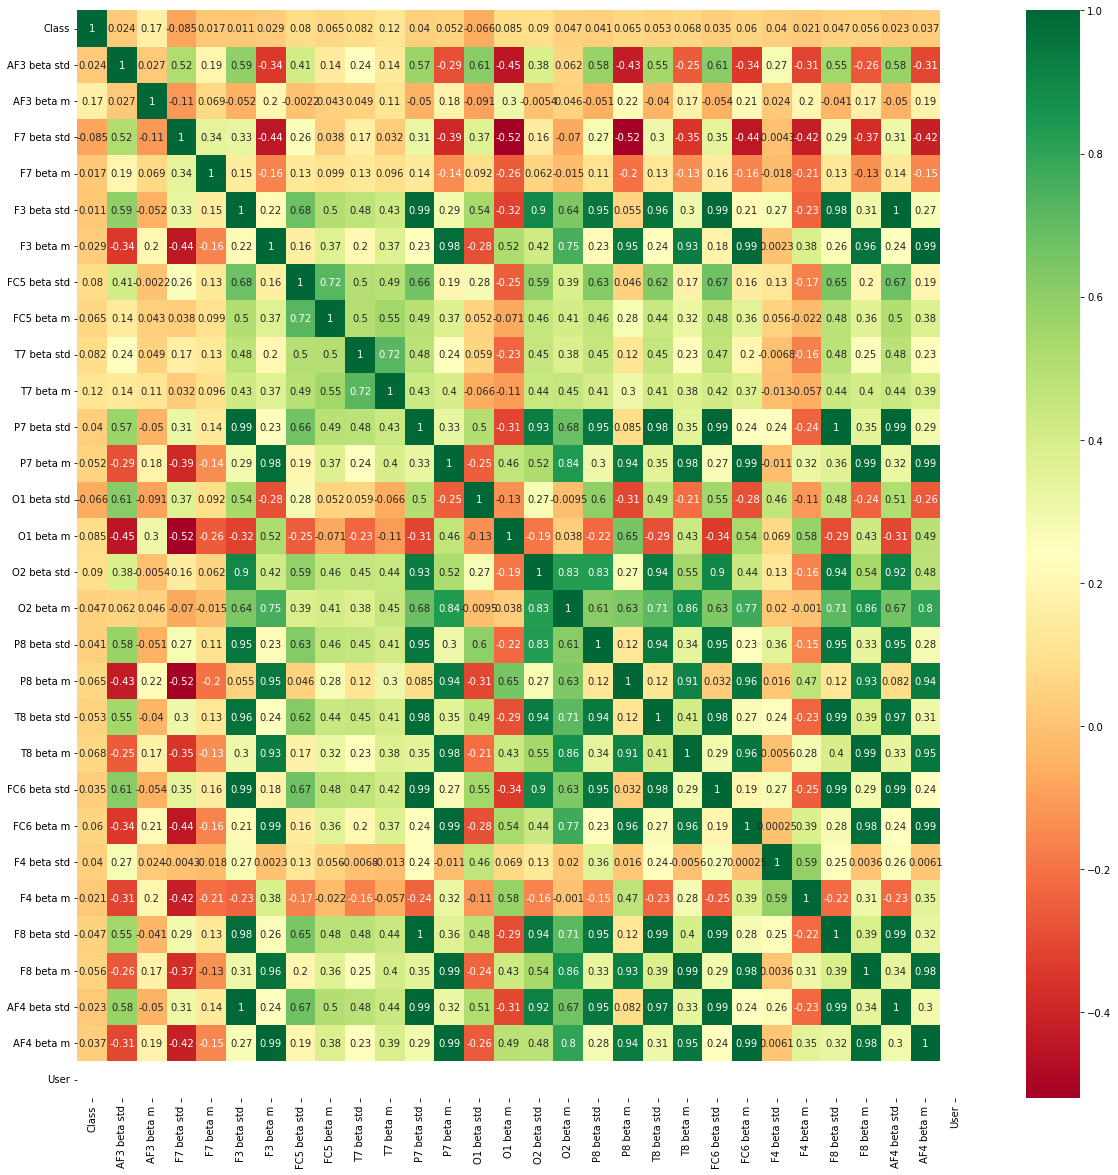

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")